In [1]:
# 1. Import Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, metrics, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
#from sklearn import metrics

In [2]:
# 2. Load Data

df = pd.read_csv('./melting_tank.csv',
                 parse_dates=['STD_DT'],
                 infer_datetime_format=True,
                 index_col='STD_DT'
                )
df.drop(['NUM'],axis=1,inplace=True) # NUM column 제거

In [3]:
df

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,
2020-03-04 00:00:00,489,116,631,3.19,OK
2020-03-04 00:00:00,433,78,609,3.19,OK
2020-03-04 00:00:00,464,154,608,3.19,OK
2020-03-04 00:00:00,379,212,606,3.19,OK
2020-03-04 00:00:00,798,1736,604,3.21,OK
...,...,...,...,...,...
2020-04-30 23:59:00,755,1743,318,3.21,OK
2020-04-30 23:59:00,385,206,317,3.19,OK
2020-04-30 23:59:00,465,148,316,3.20,OK


In [4]:
encoder = preprocessing.LabelEncoder()
df['TAG'] = encoder.fit_transform(df['TAG']) # categorical variable to numerical variable
df['TAG'] = df['TAG'].astype(int)

In [5]:
print(f'data shape = {df.shape}')
df.head(20)

data shape = (835200, 5)


,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,
2020-03-04 00:00:00,489,116,631,3.19,1
2020-03-04 00:00:00,433,78,609,3.19,1
2020-03-04 00:00:00,464,154,608,3.19,1
2020-03-04 00:00:00,379,212,606,3.19,1
2020-03-04 00:00:00,798,1736,604,3.21,1
2020-03-04 00:00:00,743,1722,603,3.21,1
2020-03-04 00:00:00,390,212,602,3.19,1
2020-03-04 00:00:00,493,152,600,3.19,1
2020-03-04 00:00:00,427,0,599,3.19,1


In [6]:
Counter(df['TAG']) # 1이 normal, 0이 abnormal

Counter({1: 658133, 0: 177067})

In [27]:
input_x = df.drop('TAG', axis=1).values
input_y = df['TAG'].values

n_features = input_x.shape[1]

In [8]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data)-window_size):
        feature_list.append(data[i:i+window_size])
        label_list.append(label[i+window_size])
    return np.array(feature_list), np.array(label_list)

In [9]:
def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [28]:
scaler = MinMaxScaler().fit(input_x)
x_scaled = scaler.transform(input_x)

In [29]:
from imblearn.combine import SMOTETomek

smtt = SMOTETomek()

In [30]:
x_scaled, input_y = smtt.fit_resample(x_scaled, input_y)

In [33]:
x_scaled.shape

(1202286, 10, 4)

In [32]:
x_scaled ,y_sequence = make_dataset(x_scaled,input_y,10)

In [34]:
temp_fft = np.array(list(map(lambda x: np.fft.fft(x[:,0])/10  , x_scaled)))
speed_fft = np.array(list(map(lambda x: np.fft.fft(x[:,1])/10  , x_scaled)))
weight_fft = np.array(list(map(lambda x: np.fft.fft(x[:,2])/10  , x_scaled)))

In [35]:
temp_fft = temp_fft[:,:,np.newaxis]
speed_fft = speed_fft[:,:,np.newaxis]
weight_fft = weight_fft[:,:,np.newaxis]

In [36]:
x_scaled.shape, temp_fft.shape

((1202286, 10, 4), (1202286, 10, 1))

In [37]:
new_x = np.concatenate([x_scaled,temp_fft,speed_fft,weight_fft],axis=2)

In [38]:
new_x.shape

(1202286, 10, 7)

In [39]:
y_sequence.shape

(1202286,)

In [40]:
# Split into train, valid, and test 
x_train, x_test, y_train, y_test = train_test_split(new_x, y_sequence, test_size=0.3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3)

print(len(x_train))  
print(len(x_valid))
print(len(x_test)) 

589120
252480
360686


In [41]:
# For training the autoencoder, split 0 / 1
x_train_y0 = x_train[y_train == 0] # 비정상
x_train_y1 = x_train[y_train == 1] # 정상

x_valid_y0 = x_valid[y_valid == 0] # 비정상
x_valid_y1 = x_valid[y_valid == 1] # 정상

In [42]:
# 7. Training LSTM Autoencoder

epochs = 30
batch = 32
lr = 0.0001

In [43]:
# F1-Score Metric으로 사용하기위한 함수
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [44]:
n_features = 7

In [45]:
timesteps = 10

In [46]:
lstm_ae = models.Sequential()
# Encoder
lstm_ae.add(layers.LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=False))
lstm_ae.add(layers.RepeatVector(timesteps))
# Decoder
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=True))
lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))

lstm_ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 32)            5120      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 32)            6272      
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 7)             231       
Total params: 16,871
Trainable params: 16,871
Non-trainable params: 0
____________________________________________________

In [46]:
# compile
lstm_ae.compile(loss='mse',  
                metrics=[get_f1],
                optimizer=optimizers.Adam(lr))

early_stop = EarlyStopping(monitor='val_loss', patience=5)

# fit
history = lstm_ae.fit(x_train_y0, x_train_y0,
                     epochs=epochs, 
                     batch_size=batch,
                     validation_data=(x_valid_y0, x_valid_y0),
                     callbacks=[early_stop])

Exception ignored in: <bound method ScopedTFGraph.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFGraph object at 0x7f5daaadc4e0>>
Traceback (most recent call last):
  File "/home/jhpark/anaconda3/envs/graph/lib/python3.6/site-packages/tensorflow/python/framework/c_api_util.py", line 58, in __del__
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/jhpark/anaconda3/envs/graph/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-445f95d91c2f>", line 13, in <module>
    callbacks=[early_stop])
  File "/home/jhpark/anaconda3/envs/graph/lib/python3.6/site-packages/keras/engine/training.py", line 1148, in fit
    steps_per_execution=self._steps_per_execution)
  File "/home/jhpark/anaconda3/envs/graph/lib/python3.6/site-packages/keras/engine/data_adapter.py", line 1383, in get_data_handler
    return DataHandler(*args, **kwargs)
  File "/home/jhpark/anaconda3/envs/graph/lib/python3.6/site-packages/keras/engine/data_adapter.py", line 1150, in __init__
    model=model)
  File "/home/jhpark/anaconda3/envs/graph/lib/python3.6/site-packages/keras/engine/data_adapter.py", line 286, in __init__
    indices_dataset = indices_dataset.map(permutation).prefetch(1)
  File "/home/jhpark/an

TypeError: object of type 'NoneType' has no len()

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [36]:
def flatten(X):
    flattened_X = np.empty((X.shape[0],X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i,(X.shape[1]-1),:]
    return (flattened_X)

/home/jhpark/anaconda3/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


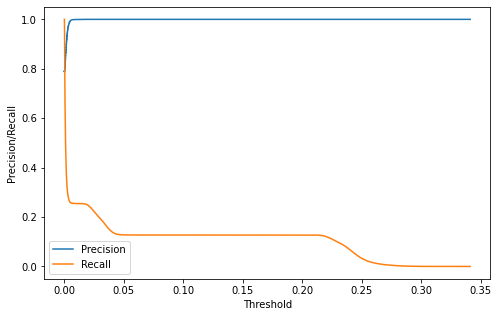

In [37]:
# 8. Threshold by Precision Recall Curve
from sklearn import metrics
valid_x_predictions = lstm_ae.predict(x_valid)
mse = np.mean(np.power(flatten(x_valid) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error':mse, 
                         'True_class':list(y_valid)})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [38]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.8002299615284487 , recall:  0.8002299615284487
threshold:  0.0003503154853055317


/home/jhpark/anaconda3/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


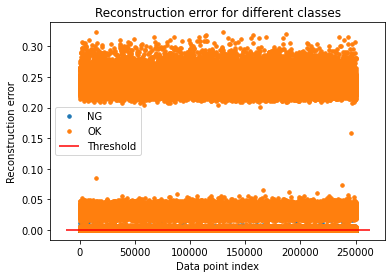

In [39]:
# 9. Predict Test

test_x_predictions = lstm_ae.predict(x_test)
mse = np.mean(np.power(flatten(x_test) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "OK" if name == 1 else "NG")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

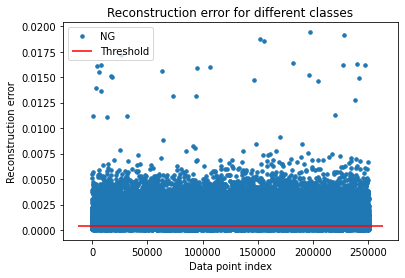

In [40]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 0:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "NG")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [41]:
OK_df = error_df[error_df['True_class']==1]
NG_df = error_df[error_df['True_class']==0]

In [42]:
NG_df

,Reconstruction_error,True_class
11,0.000526,0
12,0.001046,0
13,0.000321,0
15,0.000792,0
22,0.000352,0
...,...,...
250546,0.001325,0
250548,0.001819,0
250550,0.000572,0
250551,0.000366,0


In [43]:
OK_df

,Reconstruction_error,True_class
0,0.000137,1
1,0.000448,1
2,0.031913,1
3,0.020993,1
4,0.001007,1
...,...,...
250549,0.000957,1
250553,0.029745,1
250554,0.000168,1
250555,0.000555,1


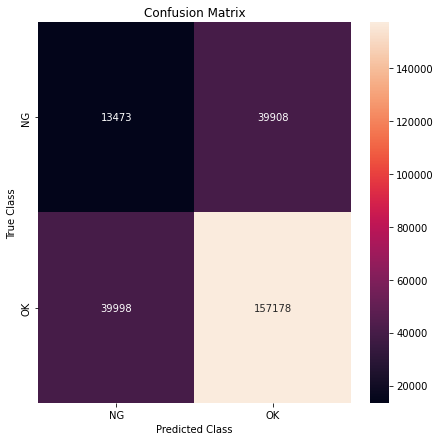

In [44]:
# 10. Evaluation: confusion matrix
LABELS = ['NG', 'OK']
# classification by threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]

conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

In [45]:
print("Precision", metrics.precision_score(error_df['True_class'], pred_y))
print("Recall", metrics.recall_score(error_df['True_class'], pred_y))
print("F1-score", metrics.f1_score(error_df['True_class'], pred_y))
print("Accuracy", metrics.accuracy_score(error_df['True_class'], pred_y))

Precision 0.7975097165704312
Recall 0.7971456972451009
F1-score 0.7973276653595833
Accuracy 0.6810865391906832


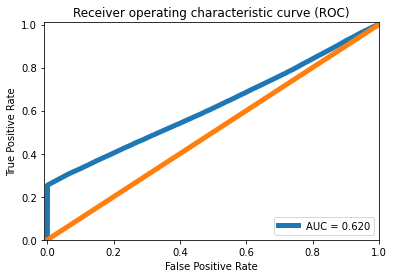

In [46]:
# ROC Curve and AUC

false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(error_df['True_class'], error_df['Reconstruction_error'])
roc_auc = metrics.auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.show()